# 02: Merging survey data, and initial preprocessing

# Contents

1. Introduction
2. Merging National Survey of College Graduates datasets (2017, 2019, 2021)
3. Inspecting datatypes
4. Addressing changes to the datatypes
5. Final checks for missing values and duplicates
6. Exploring cleaned dataset as .csv file
7. Summary
 


## **1. Introduction**

During Sprint 1, we loaded in our dataset and conducted preliminary EDA to understand the nature of our dataset, features and further areas of exploration. 

Now, we'll build on the work conducted during Sprint 1, to ensure our data loading and cleaning is complete, performing EDA of all relevant datasets before moving on to construct our baseline models. 

We can use the preliminary data analysis we carried out on the 2021 dataset, to act as a template for our approach to loading data, cleaning and initial preprocessing to get ready for our final EDA. ([See Sprint 1 notebook](./01%20Introduction%20to%20Data%20and%20Preliminary%20EDA.ipynb))

**By the end of this notebook, we aim to have cleaned and prepared our merged dataset for some very initial preprocessing - including inspecting column datatypes, converting initial columns to the appropriate datatype and getting ready for further EDA and preprocessing required.**


## **2. Merging National Survey of College Graduates datasets (2017, 2019, 2021)**

We'll be focusing on combining survey responses across **three datasets** / timeppoints:


* **2015 Dataset**: This dataset captures the state of the U.S. college graduate workforce in 2015. It was part of the regular NSCG cycle, providing insights into the educational background and employment status of graduates as of that year.

* **2017 Dataset**: This dataset captures the state of the U.S. college graduate workforce in 2017. It was part of the regular NSCG cycle, providing insights into the educational background and employment status of graduates as of that year.

* **2019 Dataset**: Two years later, the 2019 dataset was released, continuing to track the same trends but reflecting any changes or shifts in the workforce over that period. This dataset is particularly valuable for understanding how the job market evolved during these years, especially in response to technological advancements and other economic factors.

* **2021 Dataset**: The most recent dataset, from 2021, provides a post-pandemic snapshot of the college graduate workforce. This survey cycle is crucial for understanding the impact of COVID-19 on job satisfaction, employment status, and salary trends among graduates.

We chose the 2015, 2017, 2019, and 2021 datasets to provide a balanced view of the U.S. college graduate workforce, covering enough pre-pandemic years (2015-2019) to establish trends before the major disruptions of COVID-19. This allows for a clear comparison between pre- and post-pandemic workforce conditions. The 2013 dataset was omitted as the more recent datasets are sufficient for capturing relevant trends without going too far back in time.

However, we do note the limitation of post-pandemic public use data which is available only until 2021. Future iterations of the project can incorporate new releases of data over time.

(See link to source data here: https://ncses.nsf.gov/explore-data/microdata/national-survey-college-graduates)

### (a) Initial inspection and filtering of dataset

Importing necessary libraries:

In [305]:
# Importing essential libraries
import pandas as pd          
import numpy as np         
import matplotlib.pyplot as plt  
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import os

During Sprint 1, we loaded in one dataset, which gave us an idea of the structure of the data. Using this, we can now load each relevant year's dataset. apply any necessary decoding for byte-to-string conversion, and add a year identifier.

In [306]:
years = [2015, 2017, 2019, 2021]
datasets = {}

for year in years:
    # last two digits of the year for the folder name
    folder_suffix = str(year)[-2:]  # '15', '17', etc.
    
    # file path
    dataset_path = f"../data/pcg{folder_suffix}Public/epcg{folder_suffix}.sas7bdat"
    
    # Load the dataset
    print(f"Loading dataset from: {dataset_path}")
    nscg = pd.read_sas(dataset_path)
    
    # Convert byte to string where needed
    nscg = nscg.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

    # Add year identifier column
    nscg['survey_year'] = year
    
    # Store the dataset
    datasets[year] = nscg



Loading dataset from: ../data/pcg15Public/epcg15.sas7bdat


/var/folders/d8/f47z80nj3835j2cjhqsrtc6r0000gn/T/ipykernel_68280/1319290939.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  nscg = nscg.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)


Loading dataset from: ../data/pcg17Public/epcg17.sas7bdat


/var/folders/d8/f47z80nj3835j2cjhqsrtc6r0000gn/T/ipykernel_68280/1319290939.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  nscg = nscg.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)


Loading dataset from: ../data/pcg19Public/epcg19.sas7bdat


/var/folders/d8/f47z80nj3835j2cjhqsrtc6r0000gn/T/ipykernel_68280/1319290939.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  nscg = nscg.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)


Loading dataset from: ../data/pcg21Public/epcg21.sas7bdat


/var/folders/d8/f47z80nj3835j2cjhqsrtc6r0000gn/T/ipykernel_68280/1319290939.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  nscg = nscg.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)


Loading the variable mapping for each year - we need to load the Excel files provided by the creators of the dataset, to help us form a mapping dictionary for each year.

In [307]:
mapping_dicts = {}

for year in [2015, 2017, 2019, 2021]:
    # Load the mapping Excel file for the given year
    map_path = f"../data/pcg{str(year)[-2:]}Public/Dpcg{str(year)[-2:]}.xlsx" #this is the file path, as given in the public use data files
    map_names = pd.read_excel(map_path)

    # Create the mapping dictionary: {SAS_NAME: (SESTAT_NAME, DESCRIPTION)}
    mapping_dict = {row['SAS_NAME']: (row['SESTAT_NAME'], row['DESCRIPTION']) for _, row in map_names.iterrows()} #iterate over the rows of a DataFrame as pairs of index and row content, _ placeholder for index which we don't need
    mapping_dicts[year] = mapping_dict

    # checking a few variable names
    print(f"Year: {year}")
    print(mapping_dict.get('LFSTAT'), mapping_dict.get('ACFPT')) #should return the tuple e.g., for LFSTAT - 'labor force stat, 'Labor force status' etc.)

Year: 2015
('A_JOB_STATUS_LABOR_FORCE_STAT', 'Labor force status') ('N_ED_REF_WK_ENROLL_FT_PT_IND', 'Taking courses/enrolled during reference week: enrollment status')
Year: 2017
('A_JOB_STATUS_LABOR_FORCE_STAT', 'Labor force status') ('N_ED_REF_WK_ENROLL_FT_PT_IND', 'Taking courses/enrolled during reference week: enrollment status')
Year: 2019
('A_JOB_STATUS_LABOR_FORCE_STAT', 'Labor force status') ('N_ED_REF_WK_ENROLL_FT_PT_IND', 'Taking courses/enrolled during reference week: enrollment status')
Year: 2021
('A_JOB_STATUS_LABOR_FORCE_STAT', 'Labor force status') ('N_ED_REF_WK_ENROLL_FT_PT_IND', 'Taking courses/enrolled during reference week: enrollment status')


/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Next, we want to filter to focus on employed individuals who responded to the survey **only**. To make sure we're interpreting meaning of variables correctly, we look at the variable guides below:

* [2015 PDF](../data/pcg15Public/Ppcg15.pdf)
* [2017 PDF](../data/pcg17Public/Ppcg17.pdf)
* [2019 PDF](../data/pcg19Public/Ppcg19.pdf)
* [2021 PDF](../data/pcg21Public/Ppcg21.pdf)



In [308]:
filtered_datasets = {}

for year in [2015, 2017, 2019, 2021]:
    # Get the dataset
    nscg = datasets[year].copy()

    # Any replacements needed (e.g., 'L' to '3' in ACFPT), to group together anyone NOT in a full-time or part-time degree at time of survey
    nscg['ACFPT'] = nscg['ACFPT'].replace({'L': 3})

    # Convert LFSTAT and ACFPT to numeric types (if not already)
    nscg['LFSTAT'] = pd.to_numeric(nscg['LFSTAT'], errors='coerce')
    nscg['ACFPT'] = pd.to_numeric(nscg['ACFPT'], errors='coerce')

    # Filter for employed individuals (LFSTAT == 1) who are not enrolled in a degree program (ACFPT == 3)
    employed_nscg = nscg[(nscg['LFSTAT'] == 1) & (nscg['ACFPT'] == 3)]

    # Drop the LFSTAT and ACFPT columns as they have served their purpose
    employed_nscg.drop(columns=['LFSTAT', 'ACFPT'], inplace=True)

    # Store the filtered dataset
    filtered_datasets[year] = employed_nscg

    # Optionally, print the shape to verify the filtering worked
    print(f"Year: {year}, Filtered Shape: {employed_nscg.shape}")


/var/folders/d8/f47z80nj3835j2cjhqsrtc6r0000gn/T/ipykernel_68280/1092807886.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  employed_nscg.drop(columns=['LFSTAT', 'ACFPT'], inplace=True)


Year: 2015, Filtered Shape: (71919, 529)


/var/folders/d8/f47z80nj3835j2cjhqsrtc6r0000gn/T/ipykernel_68280/1092807886.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  employed_nscg.drop(columns=['LFSTAT', 'ACFPT'], inplace=True)


Year: 2017, Filtered Shape: (65738, 519)


/var/folders/d8/f47z80nj3835j2cjhqsrtc6r0000gn/T/ipykernel_68280/1092807886.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  employed_nscg.drop(columns=['LFSTAT', 'ACFPT'], inplace=True)


Year: 2019, Filtered Shape: (73794, 516)
Year: 2021, Filtered Shape: (84077, 536)


/var/folders/d8/f47z80nj3835j2cjhqsrtc6r0000gn/T/ipykernel_68280/1092807886.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  employed_nscg.drop(columns=['LFSTAT', 'ACFPT'], inplace=True)


### (b) Renaming columns for consistency and readability

In our initial exploration, we encountered over 500 columns of data. While this dataset is comprehensive, not all variables are relevant to assessing job match success. Guided by theory and supported by literature (see examples of references below), we have begun by exploring key variables that align with the core dimensions of job match success: Financial Success, Job Satisfaction, and Skills Match. 

We’ve excluded columns that are not pertinent to these dimensions.

Please see the data dictionary presented below:

References:
* Higher Education Statistics Agency (HESA). (2020). Career Satisfaction by Ethnicity.
* Spector, P. E. (1997). Job Satisfaction: Application, Assessment, Causes, and Consequences.
* HiRize. (2021). How ML-Based Job-Resume Matching Algorithms Work.

### Data Dictionary:

| Raw Data - Variable_Name   | Variable Name              | Description                                              | Data Structure                                                                                                           |
|----------------------------|----------------------------|----------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------|
| JOBSATIS                    | job_satisfaction           | Job satisfaction                                         | 1: Very satisfied, 2: Somewhat satisfied, 3: Somewhat dissatisfied, 4: Very dissatisfied, L: Logical Skip                |
| SATSAL                      | satisfaction_salary        | Satisfaction with job's salary                           | 1: Very satisfied, 2: Somewhat satisfied, 3: Somewhat dissatisfied, 4: Very dissatisfied, L: Logical Skip                |
| SATADV                      | satisfaction_advancement   | Satisfaction with advancement opportunities              | 1: Very satisfied, 2: Somewhat satisfied, 3: Somewhat dissatisfied, 4: Very dissatisfied, L: Logical Skip                |
| SATBEN                      | satisfaction_benefits      | Satisfaction with benefits                               | 1: Very satisfied, 2: Somewhat satisfied, 3: Somewhat dissatisfied, 4: Very dissatisfied, L: Logical Skip                |
| SATCHAL                     | satisfaction_challenges    | Satisfaction with job's intellectual challenge            | 1: Very satisfied, 2: Somewhat satisfied, 3: Somewhat dissatisfied, 4: Very dissatisfied, L: Logical Skip                |
| SATLOC                      | satisfaction_location      | Satisfaction with job location                           | 1: Very satisfied, 2: Somewhat satisfied, 3: Somewhat dissatisfied, 4: Very dissatisfied, L: Logical Skip                |
| SATSEC                      | satisfaction_security      | Satisfaction with job security                           | 1: Very satisfied, 2: Somewhat satisfied, 3: Somewhat dissatisfied, 4: Very dissatisfied, L: Logical Skip                |
| SALARY                      | salary                     | Salary (annualized)                                      | 0-9999996: Value, 9999998: Logical Skip                                                                                   |
| FACSOC                      | importance_society_contribution | Self-rated assessment of job's contribution to society   | 1: Very important, 2: Somewhat important, 3: Somewhat unimportant, 4: Not important at all, L: Logical Skip             |
| OCEDRLP                     | job_degree_relation        | Extent that principal job is related to highest degree    | 1: Closely related, 2: Somewhat related, 3: Not related, L: Logical Skip                                                 |
| N2MRMED                     | recent_degree_field        | Field of study of major for the most recent degree        | Code for field of study during reference week - best code                                                                |
| MRDG                        | recent_degree_type         | Type of degree for most recent degree                    | 1 - Bachelor's, 2 - Master's, 3 - Doctorate, 4 - Professional degree                                                    |
| MRDACYR                     | academic_year_most_recent_degree | Academic year of award for most recent degree           | Year of most recent degree completion (numeric)                                                                         |
| GENDER                      | gender                     | Gender                                                   | F: Female, M: Male                                                                                                       |
| AGE                         | age                        | Age                                                      | Age number                                                                                                              |
| AGEGR                       | age_group                  | Age group (5-year intervals)                             | 20: Ages 24 or younger, 25: Ages 25-29, 30: Ages 30-34, etc.                                                             |
| RACEM                       | race                       | Race                                                     | 1: Asian ONLY, 2: American Indian/Alaska Native ONLY, 3: Black ONLY, 4: White ONLY, 5: Native Hawaiian/Other Pacific Islander ONLY, 6: Multiple Race |
| EMSECDT                     | employer_sector_detailed   | Employer sector (detailed codes)                         | 11: 4-yr college/university, 12: 2-yr college, 21: Business/Industry, 22: Government, etc.                               |
| EMSECSM                     | employer_sector_summary    | Employer sector (summary codes)                          | 1: Educational Institution, 2: Government, 3: Business/Industry, L: Logical Skip                                         |
| EMSIZE                      | employer_size              | Employer size                                            | 1: 10 or fewer employees, 2: 11-24 employees, 3: 25-99 employees, 4: 100-499 employees, etc.                             |
| EMST                        | employer_location          | State/country code for employer                          | Various codes for U.S. regions, states, and countries, L: Logical Skip                                                   |
| MARSTA                      | marital_status             | Marital Status                                           | 1: Married, 2: Living in a marriage-like relationship, 3: Widowed, 4: Separated, 5: Divorced, 6: Never married          |
| RESPLO3                     | respondent_location_code   | 3-Digit respondent location (state/country code)         | Various codes for U.S. regions, states, and countries, L: Logical Skip                                                   |
| CTZUSIN                     | citizenship_status         | U.S. citizenship status                                  | N: Non-U.S. citizen, Y: U.S. citizen                                                                                     |
| CHLVIN                      | children_in_household      | Children living in household                             | N: No, Y: Yes                                                                                                            |
| CLICNMBR                    | active_certifications      | Number of active certifications/licenses                 | Numeric value: 0 - n certifications/licenses currently active                                                            |
| LWMN                        | last_worked_month          | Month when the individual last worked before the current job | 1-12: Month (1 for January, 2 for February, etc.)                                                                        |
| LWYR                        | last_worked_year           | Year when the individual last worked before the current job | Year (numeric)                                                                                                          |
| STRTYR                      | start_year_current_job     | Year when the individual started their current principal job | Year (numeric)                                                                                                          |                                |
| N3OCPR                      | occupation_name            | Occupation code for the principal job                    | Code that best describes the principal job held during the week of February 1                                            |


### Based on the above, let's keep all these relevant columns and merge datasets

There are some discrepancies in the variable names for 2015/2017 versus later years, so our code will have to align this.

In [309]:
#Checking discrpenacies for the N2MRMED variable (recent degree field)
for year, df in filtered_datasets.items():
    print(f"Year: {year}, Possible matches: {[col for col in df.columns if 'N2MR' in col]}")


Year: 2015, Possible matches: []
Year: 2017, Possible matches: []
Year: 2019, Possible matches: ['N2MRMED', 'N2MRMEDX', 'N2MRNED', 'N2MRNEDX']
Year: 2021, Possible matches: ['N2MRMED', 'N2MRMEDX', 'N2MRNED', 'N2MRNEDX']


In [310]:
# Rename 'NMRMED' to 'N2MRMED' for 2015 and 2017 datasets
for year in [2015, 2017]:
    if 'NMRMED' in filtered_datasets[year].columns:
        filtered_datasets[year].rename(columns={'NMRMED': 'N2MRMED'}, inplace=True)

In [311]:
# Rename 'N2OCPR' to 'N3OCPR' for 2015 and 2017 datasets
for year in [2015, 2017]:
    if 'N2OCPR' in filtered_datasets[year].columns:
        filtered_datasets[year].rename(columns={'N2OCPR': 'N3OCPR'}, inplace=True)

In [312]:
# Check if 'N3OCPR' is present in each year and count the number of missing values
for year, dataset in filtered_datasets.items():
    if 'N3OCPR' in dataset.columns:
        missing_count = dataset['N3OCPR'].isna().sum()  # Count the number of missing values (NaN)
        print(f"In {year}, 'N3OCPR' is present with {missing_count} missing values.")
    else:
        print(f"In {year}, 'N3OCPR' is not present.")

In 2015, 'N3OCPR' is present with 0 missing values.
In 2017, 'N3OCPR' is present with 0 missing values.
In 2019, 'N3OCPR' is present with 0 missing values.
In 2021, 'N3OCPR' is present with 0 missing values.


Check for any duplicated columns first across all dataframes:

In [313]:
# Check for duplicate column names and remove them
for year, df in filtered_datasets.items():
    # Check for duplicated columns
    duplicate_columns = df.columns[df.columns.duplicated()].tolist()
    
    if duplicate_columns:
        print(f"Year {year} has duplicate columns: {duplicate_columns}")
    
    # Remove duplicate columns (keeping the first occurrence)
    df_cleaned = df.loc[:, ~df.columns.duplicated()].copy()
    
    # Update the dictionary with the cleaned DataFrame
    filtered_datasets[year] = df_cleaned


In [314]:
# List of relevant columns to keep
relevant_columns = [
    'JOBSATIS', 'SATSAL', 'SATADV', 'SATBEN', 'SATCHAL', 'SATLOC', 'SATSEC', 'SALARY', 
    'FACSOC', 'OCEDRLP', 'N2MRMED', 'MRDG', 'MRDACYR', 'GENDER', 'AGE', 'AGEGR', 
    'RACEM', 'EMSECDT', 'EMSECSM', 'EMSIZE', 'EMST', 'MARSTA', 'RESPLO3', 'CTZUSIN', 
    'CHLVIN', 'CLICNMBR', 'LWMN', 'LWYR', 'STRTYR', 'survey_year','N3OCPR'
]

# Dictionary for renaming columns to readable names
rename_columns = {
    'JOBSATIS': 'job_satisfaction',
    'SATSAL': 'satisfaction_salary',
    'SATADV': 'satisfaction_advancement',
    'SATBEN': 'satisfaction_benefits',
    'SATCHAL': 'satisfaction_challenges',
    'SATLOC': 'satisfaction_location',
    'SATSEC': 'satisfaction_security',
    'SALARY': 'salary',
    'FACSOC': 'importance_society_contribution',
    'OCEDRLP': 'job_degree_relation',
    'N2MRMED': 'recent_degree_field',
    'MRDG': 'recent_degree_type',
    'MRDACYR': 'academic_year_most_recent_degree',
    'GENDER': 'gender',
    'AGE': 'age',
    'AGEGR': 'age_group',
    'RACEM': 'race',
    'EMSECDT': 'employer_sector_detailed',
    'EMSECSM': 'employer_sector_summary',
    'EMSIZE': 'employer_size',
    'EMST': 'employer_location',
    'MARSTA': 'marital_status',
    'RESPLO3': 'respondent_location_code',
    'CTZUSIN': 'citizenship_status',
    'CHLVIN': 'children_in_household',
    'CLICNMBR': 'active_certifications',
    'LWMN': 'last_worked_month',
    'LWYR': 'last_worked_year',
    'STRTYR': 'start_year_current_job',
    'survey_year': 'survey_year',
    'N3OCPR': 'occupation_name',
}

# Initialize an empty list to hold the renamed and filtered datasets
renamed_datasets = []

# Process each year's dataset from the filtered_datasets
for year, df in filtered_datasets.items():
    # Filter relevant columns that exist in the dataset
    existing_columns = [col for col in relevant_columns if col in df.columns]
    df_filtered = df[existing_columns].copy()

    # Rename columns using the dictionary
    df_filtered.rename(columns=rename_columns, inplace=True)

    # Append this year's processed dataset to the list
    renamed_datasets.append(df_filtered)

# Concatenate all years into a single DataFrame
employed_final = pd.concat(renamed_datasets, ignore_index=True)

# Check the final result
print(employed_final.head())


  job_satisfaction satisfaction_salary satisfaction_advancement  \
0                1                   2                        2   
1                2                   2                        3   
2                2                   2                        3   
3                2                   3                        3   
4                1                   2                        2   

  satisfaction_benefits satisfaction_challenges satisfaction_location  \
0                     2                       1                     1   
1                     3                       2                     1   
2                     1                       1                     2   
3                     4                       1                     1   
4                     2                       1                     1   

  satisfaction_security   salary importance_society_contribution  \
0                     2  38000.0                               1   
1                     

Double checking the shape of our merged data frame, with data from survey years 2015, 2017, 2019 and 2021:

In [315]:
# Check the shape of the final DataFrame
print(f"Shape of final DataFrame: {employed_final.shape}")

Shape of final DataFrame: (295528, 31)


### (c) Final check of merged dataframe

Checking for any duplicates again:

In [316]:
# Check for duplicate rows
duplicate_rows = employed_final.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# Check for duplicate columns by transposing the DataFrame and checking for duplicated rows
duplicate_columns = employed_final.T.duplicated().sum()
print(f"Number of duplicate columns: {duplicate_columns}")


Number of duplicate rows: 205
Number of duplicate columns: 0


Dropping any duplicates as required:

In [317]:
#Dropping duplicate rows
employed_final.drop_duplicates(inplace=True)

#Sanity check
duplicate_rows = employed_final.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


Checking for any missing values:

In [318]:
# Check for missing values: number and proportion per column
missing_values = employed_final.isna().sum()  # Total missing values per column
missing_proportion = employed_final.isna().mean()  # Proportion of missing values per column

# Print missing values and their proportions
print("Missing values and proportions per column:")
for col in employed_final.columns:
    if missing_values[col] > 0:
        print(f"{col}: Missing: {missing_values[col]}, Proportion: {missing_proportion[col]:.2%}")

Missing values and proportions per column:


It looks like we have no missing values in our final merged dataset.

# **3. Inspecting datatypes**

In [319]:
employed_final.dtypes

job_satisfaction                     object
satisfaction_salary                  object
satisfaction_advancement             object
satisfaction_benefits                object
satisfaction_challenges              object
satisfaction_location                object
satisfaction_security                object
salary                              float64
importance_society_contribution      object
job_degree_relation                  object
recent_degree_field                  object
recent_degree_type                   object
academic_year_most_recent_degree    float64
gender                               object
age                                 float64
age_group                           float64
race                                 object
employer_sector_detailed             object
employer_sector_summary              object
employer_size                        object
employer_location                    object
marital_status                       object
respondent_location_code        

As we saw during Sprint 1, and using our data dictionary, some of our object variables - particularly those relating to 'job satisfaction' - have rather unintuitive coding. We can also consider reversing the coding of these ratings to be more intuitive - currently '1' is the highest rating for satisfaction, but we could turn this into '4' as the highest rating.

### To understand this better, let's look at the structure of all of our object datatypes, for all years combined:


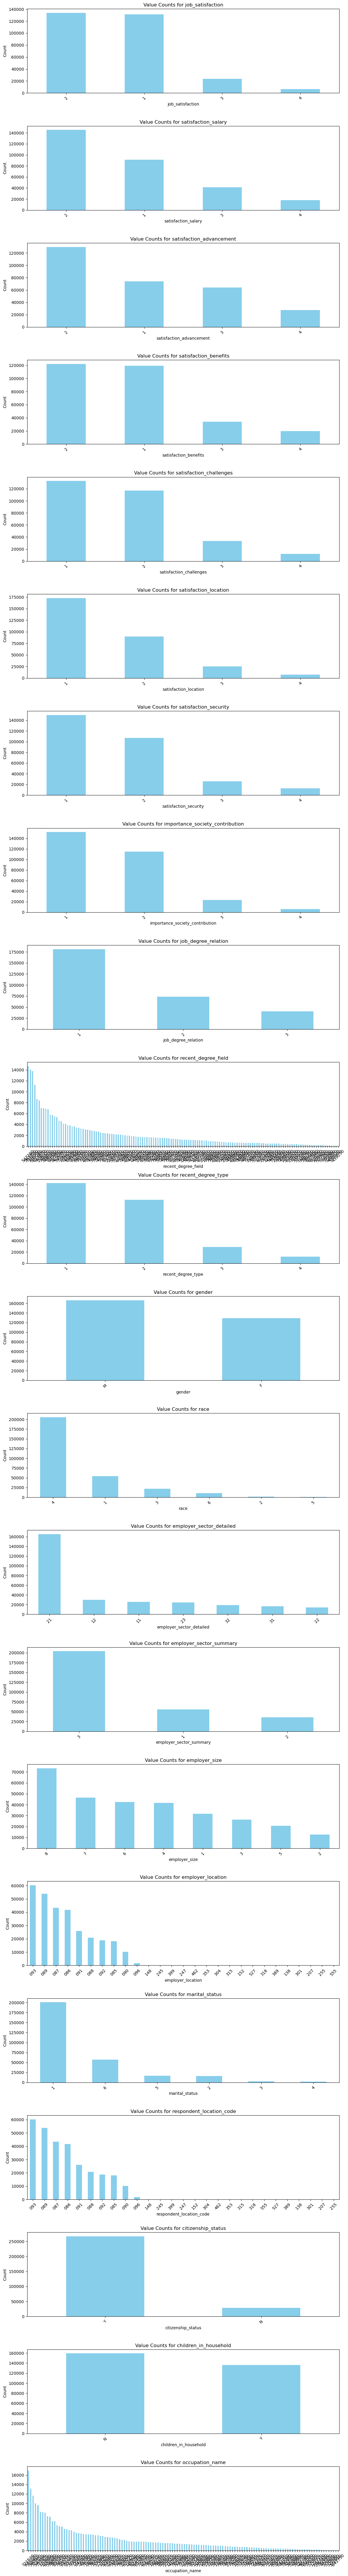

In [320]:
# Filter only object dtype columns
object_columns = employed_final.select_dtypes(include=['object']).columns

# Set up the plot size and layout
plt.figure(figsize=(12, len(object_columns) * 4))

# Loop through each object column and plot the value counts
for i, col in enumerate(object_columns, 1):
    plt.subplot(len(object_columns), 1, i)
    employed_final[col].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Value Counts for {col}')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### As we can see above, there are a number of issues with the data:

1. We've not presented our 'ordinal' variables correctly, in relation to job satisfaction scores. We would want to reverse these numbers so we can associate higher number with higher scores i.e., better job satisfaction, and convert these to int format since we know we want to eventually use them as part of our composite job satisfaction score variable

2. The coding of the categories in the data as it stands is currently not interpretable - so we need to look back to the documentation to identify the names of groupings for e.g., ehtnicity, marital status, race, degree type and beyond

# Let's address these in turn, before then identifying the necessary datatype conversions:

**************

## Creating a deepcopy of our df first:

In [321]:
employed_final_new = employed_final.copy()

## (1) Variables linked to 'job satisfaction' scores

In [322]:
# List of relevant satisfaction-related columns
satisfaction_cols = [
    'job_satisfaction',
    'satisfaction_salary',
    'satisfaction_advancement',
    'satisfaction_benefits',
    'satisfaction_challenges',
    'satisfaction_location',
    'satisfaction_security',
    'importance_society_contribution',
    'job_degree_relation'
]

# Mapping for reversal
reversal_map = {
    '1': '4',
    '2': '3',
    '3': '2',
    '4': '1'
}

# Apply the mapping to each column in satisfaction_cols
for col in satisfaction_cols:
    employed_final_new[col] = employed_final[col].map(reversal_map).astype(int)

# Check the result
print(employed_final_new[satisfaction_cols].head())


   job_satisfaction  satisfaction_salary  satisfaction_advancement  \
0                 4                    3                         3   
1                 3                    3                         2   
2                 3                    3                         2   
3                 3                    2                         2   
4                 4                    3                         3   

   satisfaction_benefits  satisfaction_challenges  satisfaction_location  \
0                      3                        4                      4   
1                      2                        3                      4   
2                      4                        4                      3   
3                      1                        4                      4   
4                      3                        4                      4   

   satisfaction_security  importance_society_contribution  job_degree_relation  
0                      3                 

## (2) Ensuring interpretability of our categorical variables

### Looking at our columns, we can see we need to map certain categorical columns to have more meaningful groupings:

In [323]:
#Remind of object columns
object_columns

Index(['job_satisfaction', 'satisfaction_salary', 'satisfaction_advancement',
       'satisfaction_benefits', 'satisfaction_challenges',
       'satisfaction_location', 'satisfaction_security',
       'importance_society_contribution', 'job_degree_relation',
       'recent_degree_field', 'recent_degree_type', 'gender', 'race',
       'employer_sector_detailed', 'employer_sector_summary', 'employer_size',
       'employer_location', 'marital_status', 'respondent_location_code',
       'citizenship_status', 'children_in_household', 'occupation_name'],
      dtype='object')

## **Step 1: Double-checking any binary mapping we can do:**

### 1. Turning `Gender` and `children_in_household` into a binary variable:

In [324]:
# Gender: Map M/F to binary and rename the variable to 'female'
employed_final_new['female'] = employed_final_new['gender'].map({'M': 0, 'F': 1})

# After mapping, it's safe to drop the old 'gender' column if no longer needed
employed_final_new = employed_final_new.drop(columns=['gender'])

### 2. As we saw in the visualisations above, there is a significant imbalance in value counts for the `Employer Sector` category. We can aggregate this further as a result to focus on whether the sector is '21' - Business/Industry for-progit or not

In [325]:
# Create a binary column for 'business_for_profit' where 21 = 1, and everything else = 0, using a lambda function to help us with this
employed_final_new['business_for_profit'] = employed_final_new['employer_sector_detailed'].apply(lambda x: 1 if x == 21 else 0)

# Drop the old column
employed_final_new.drop(columns=['employer_sector_detailed'], inplace=True)

## **Step 2: Inspecting other object vars to aggregate categories**

### 1. `Employer Sector Summary` variable:

In [326]:
# Map employer sector summary (using string keys since it's an object type)
employed_final_new['employer_sector'] = employed_final_new['employer_sector_summary'].map({
    '1': 'Educational Institution',
    '2': 'Government',
    '3': 'Business/Industry',
    'L': 'Logical Skip'
})

# Drop the original 'employer_sector_summary' column using inplace=True
employed_final_new.drop(columns=['employer_sector_summary'], inplace=True)


In [327]:
#Sanity check
employed_final_new['employer_sector'].value_counts()

employer_sector
Business/Industry          203924
Educational Institution     55546
Government                  35853
Name: count, dtype: int64

### 2. `Employer Size` can be grouped into 3 categories, given the value counts seen earlier:

In [328]:
# Map employer size into 3 categories: Small, Medium, Large and rename to 'employer_size_category'
employed_final_new['employer_size_category'] = employed_final_new['employer_size'].map({
    '1': 'Small', '2': 'Small', '3': 'Small',  # 10-99 employees
    '4': 'Medium', '5': 'Medium',            # 100-999 employees
    '6': 'Large', '7': 'Large', '8': 'Large',  # 1000+ employees
    'L': 'Logical Skip'
})


# Drop the old 'employer_size' column with inplace=True
employed_final_new.drop(columns=['employer_size'], inplace=True)

In [329]:
#Sanity check
employed_final_new['employer_size_category'].value_counts()

employer_size_category
Large     162401
Small      70672
Medium     62250
Name: count, dtype: int64

## **Step 3: Ensuring interpretability of our category names within columns**

### 1. Mapping `Recent_degree_field` to its actual degree field names:

In [330]:
# Convert all keys in degree_mapping to strings
degree_mapping = {
    '116710': "Computer and information sciences, general",
    '116730': "Computer science",
    '116740': "Computer systems analysis",
    '116760': "Information services and systems",
    '116770': "OTHER computer and information sciences",
    '128410': "Applied mathematics",
    '128420': "Mathematics, general",
    '128430': "Operations research",
    '128440': "Statistics",
    '128450': "OTHER mathematics",
    '216050': "Animal sciences",
    '216060': "Food sciences and technology",
    '216070': "Plant sciences",
    '216080': "OTHER agricultural sciences",
    '226310': "Biochemistry and biophysics",
    '226320': "Biology, general",
    '226330': "Botany",
    '226340': "Cell and molecular biology",
    '226350': "Ecology",
    '226360': "Genetics, animal and plant",
    '226370': "Microbiological sciences and immunology",
    '226380': "Nutritional sciences",
    '226390': "Pharmacology, human and animal",
    '226400': "Physiology and pathology, human and animal",
    '226410': "Zoology, general",
    '226420': "OTHER biological sciences",
    '236800': "Environmental science or studies",
    '236810': "Forestry sciences",
    '318730': "Chemistry, except biochemistry",
    '328720': "Atmospheric sciences and meteorology",
    '328740': "Earth sciences",
    '328750': "Geology",
    '328760': "Geological sciences, other (including oceanography)",
    '338710': "Astronomy and astrophysics",
    '338780': "Physics",
    '348790': "OTHER physical sciences",
    '416010': "Agricultural economics",
    '419230': "Economics",
    '429020': "Public policy studies",
    '429270': "International relations",
    '429280': "Political science and government",
    '437040': "Educational psychology",
    '438910': "Clinical psychology",
    '438920': "Counseling psychology",
    '438930': "Experimental psychology",
    '438940': "General psychology",
    '438950': "Industrial/Organizational psychology",
    '438960': "Social psychology",
    '438970': "OTHER psychology",
    '449210': "Anthropology and archaeology",
    '449220': "Criminology",
    '449290': "Sociology",
    '456200': "Area and Ethnic Studies",
    '457710': "Linguistics",
    '458610': "Philosophy of science",
    '459240': "Geography",
    '459300': "OTHER social sciences, including history of science",
    '517210': "Aerospace, aeronautical and astronautical engineering",
    '527250': "Chemical engineering",
    '537230': "Architectural engineering",
    '537260': "Civil engineering",
    '547270': "Computer and systems engineering",
    '547280': "Electrical, electronics and communications engineering",
    '557330': "Industrial and manufacturing engineering",
    '567350': "Mechanical engineering",
    '577220': "Agricultural engineering",
    '577240': "Bioengineering and biomedical engineering",
    '577290': "Engineering sciences, mechanics and physics",
    '577300': "Environmental engineering",
    '577310': "Engineering, general",
    '577340': "Materials engineering, including ceramics and textiles",
    '577360': "Metallurgical engineering",
    '577390': "Nuclear engineering",
    '577410': "Other engineering, including geophysical, geological, mining, mineral, naval architecture, marine, and petroleum",
    '617810': "Audiology and speech pathology",
    '617820': "Health services administration",
    '617830': "Health/medical assistants",
    '617840': "Health/medical technologies",
    '617850': "Medical preparatory programs (e.g. pre-dentistry,-medical,-veterinary)",
    '617860': "Medicine (dentistry,optometry,osteopathic,podiatry,veterinary)",
    '617870': "Nursing (4 years or longer program)",
    '617880': "Pharmacy",
    '617890': "Physical therapy and other rehabilitation/therapeutic services",
    '617900': "Public health (including environmental health and epidemiology)",
    '617910': "OTHER health/medical sciences",
    '627020': "Computer teacher education",
    '627060': "Mathematics teacher education",
    '627090': "Science teacher education",
    '627120': "Social science teacher education",
    '636720': "Computer programming",
    '636750': "Data processing",
    '637510': "Electrical and electronic technologies",
    '637520': "Industrial production technologies",
    '637530': "Mechanical engineering-related technologies",
    '637540': "OTHER engineering-related technologies",
    '646100': "Architecture/Environmental Design",
    '646520': "Actuarial science",
    '716020': "OTHER agricultural business and production",
    '716510': "Accounting",
    '716530': "Business administration and management",
    '716540': "Business, general",
    '716550': "Business and managerial economics",
    '716570': "Financial management",
    '716590': "OTHER business management/administrative services",
    '727010': "Education administration",
    '727030': "Counselor education and guidance services",
    '727050': "Elementary teacher education",
    '727070': "Physical education and coaching",
    '727080': "Pre-school/kindergarten/early childhood teacher education",
    '727100': "Secondary teacher education",
    '727110': "Special education",
    '727130': "OTHER education",
    '738620': "OTHER philosophy, religion, theology",
    '739100': "Social Work",
    '746560': "Business marketing/marketing management",
    '746580': "Marketing research",
    '757600': "English Language, literature and letters",
    '757720': "OTHER foreign languages and literature",
    '758200': "Liberal Arts/General Studies",
    '759260': "History, other",
    '759410': "Dramatic arts",
    '759420': "Fine arts, all fields",
    '759430': "Music, all fields",
    '759440': "OTHER visual and performing arts",
    '766610': "Communications, general",
    '766620': "Journalism",
    '766630': "OTHER communications",
    '766820': "OTHER natural resources and conservation",
    '766900': "Criminal Justice/Protective Services",
    '768000': "Home Economics",
    '768100': "Law/Prelaw/Legal Studies",
    '768300': "Library Science",
    '768500': "Parks, Recreation, Leisure, and Fitness Studies",
    '769010': "Public administration",
    '769030': "OTHER public affairs",
    '769950': "OTHER FIELDS (Not Listed)"
}

### A slight complication here is that whilst the above mapping works well for the 2021 data, this may not be the case for all years of survey data. Here we take the 2017 datat dictionary (form the user guide) and compare to see if any mappings are missing:

In [331]:
degree_dict = {
    "116710": "Computer and information sciences",
    "116730": "Computer science",
    "116740": "Computer systems analysis",
    "116760": "Information services and systems",
    "116770": "OTHER computer and information sciences",
    "128410": "Applied mathematics",
    "128420": "Mathematics, general",
    "128430": "Operations research",
    "128440": "Statistics",
    "128450": "OTHER mathematics",
    "216050": "Animal sciences",
    "216060": "Food sciences and technology",
    "216070": "Plant sciences",
    "216080": "OTHER agricultural sciences",
    "226310": "Biochemistry and biophysics",
    "226320": "Biology, general",
    "226330": "Botany",
    "226340": "Cell and molecular biology",
    "226350": "Ecology",
    "226360": "Genetics, animal and plant",
    "226370": "Microbiological sciences and immunology",
    "226380": "Nutritional sciences",
    "226390": "Pharmacology, human and animal",
    "226400": "Physiology and pathology, human and animal",
    "226410": "Zoology, general",
    "226420": "OTHER biological sciences",
    "236800": "Environmental science or studies",
    "236810": "Forestry sciences",
    "318730": "Chemistry, except biochemistry",
    "328720": "Atmospheric sciences and meteorology",
    "328740": "Earth sciences",
    "328750": "Geology",
    "328760": "Geological sciences, other",
    "328770": "Oceanography",
    "338710": "Astronomy and astrophysics",
    "338780": "Physics",
    "348790": "OTHER physical sciences",
    "416010": "Agricultural economics",
    "419230": "Economics",
    "429020": "Public policy studies",
    "429270": "International relations",
    "429280": "Political science and government",
    "437040": "Educational psychology",
    "438910": "Clinical psychology",
    "438920": "Counseling psychology",
    "438930": "Experimental psychology",
    "438940": "General psychology",
    "438950": "Industrial/Organizational psychology",
    "438960": "Social psychology",
    "438970": "OTHER psychology",
    "449210": "Anthropology and archaeology",
    "449220": "Criminology",
    "449290": "Sociology",
    "456200": "Area and Ethnic Studies",
    "457710": "Linguistics",
    "458610": "Philosophy of science",
    "459240": "Geography",
    "459250": "History of science",
    "459300": "OTHER social sciences",
    "517210": "Aerospace, aeronautical and astronautical engineering",
    "527250": "Chemical engineering",
    "537230": "Architectural engineering",
    "537260": "Civil engineering",
    "547270": "Computer and systems engineering",
    "547280": "Electrical, electronics and communications engineering",
    "557330": "Industrial and manufacturing engineering",
    "567350": "Mechanical engineering",
    "577220": "Agricultural engineering",
    "577240": "Bioengineering and biomedical engineering",
    "577290": "Engineering sciences, mechanics and physics",
    "577300": "Environmental engineering",
    "577310": "Engineering, general",
    "577320": "Geophysical and geological engineering",
    "577340": "Materials engineering, including ceramics and textiles",
    "577360": "Metallurgical engineering",
    "577370": "Mining and minerals engineering",
    "577380": "Naval architecture and marine engineering",
    "577390": "Nuclear engineering",
    "577400": "Petroleum engineering",
    "577410": "OTHER engineering",
    "617810": "Audiology and speech pathology",
    "617820": "Health services administration",
    "617830": "Health/medical assistants",
    "617840": "Health/medical technologies",
    "617850": "Medical preparatory programs (e.g. pre-dentistry, medical, veterinary)",
    "617860": "Medicine (dentistry, optometry, osteopathic, podiatry, veterinary)",
    "617870": "Nursing (4 years or longer program)",
    "617880": "Pharmacy",
    "617890": "Physical therapy and other rehabilitation/therapeutic services",
    "617900": "Public health (including environmental health and epidemiology)",
    "617910": "OTHER health/medical sciences",
    "627020": "Computer teacher education",
    "627060": "Mathematics teacher education",
    "627090": "Science teacher education",
    "627120": "Social science teacher education",
    "636720": "Computer programming",
    "636750": "Data processing",
    "637510": "Electrical and electronic technologies",
    "637520": "Industrial production technologies",
    "637530": "Mechanical engineering-related technologies",
    "637540": "OTHER engineering-related technologies",
    "646100": "Architecture/Environmental Design",
    "646520": "Actuarial science",
    "716020": "OTHER agricultural business and production",
    "716510": "Accounting",
    "716530": "Business administration and management",
    "716540": "Business, general",
    "716550": "Business and managerial economics",
    "716570": "Financial management",
    "716590": "OTHER business management/administrative services",
    "727010": "Education administration",
    "727030": "Counselor education and guidance services",
    "727050": "Elementary teacher education",
    "727070": "Physical education and coaching",
    "727080": "Pre-school/kindergarten/early childhood teacher education",
    "727100": "Secondary teacher education",
    "727110": "Special education",
    "727130": "OTHER education",
    "738620": "OTHER philosophy, religion, theology",
    "739100": "Social Work",
    "746560": "Business marketing/marketing management",
    "746580": "Marketing research",
    "757600": "English Language, literature and letters",
    "757720": "OTHER foreign languages and literature",
    "758200": "Liberal Arts/General Studies",
    "759260": "History, other",
    "759410": "Dramatic arts",
    "759420": "Fine arts, all fields",
    "759430": "Music, all fields",
    "759440": "OTHER visual and performing arts",
    "766610": "Communications, general",
    "766620": "Journalism",
    "766630": "OTHER communications",
    "766820": "OTHER natural resources and conservation",
    "766900": "Criminal Justice/Protective Services",
    "768000": "Home Economics",
    "768100": "Law/Prelaw/Legal Studies",
    "768300": "Library Science",
    "768500": "Parks, Recreation, Leisure, and Fitness Studies",
    "769010": "Public administration",
    "769030": "OTHER public affairs",
    "769950": "OTHER FIELDS (Not Listed)"
}


### Now checking for any missing mapping that we can append to our original `degree_mapping` dictionary:

In [332]:
# Find missing mappings
missing_mappings = {k: degree_dict[k] for k in degree_dict if k not in degree_mapping}

# Append missing mappings to degree_mapping
degree_mapping.update(missing_mappings)

print(f"Appended {len(missing_mappings)} missing degree mappings.")


Appended 6 missing degree mappings.


### Applying our degree code mappings:

In [333]:
# Apply mapping to recent_degree_field (which is likely an object type with string values)
employed_final_new['recent_degree_field'] = employed_final_new['recent_degree_field'].map(degree_mapping)

### Finally, double checking for any missings in this column:

In [334]:
employed_final_new['recent_degree_field'].isna().sum()

np.int64(0)

### 2. Next, mapping `recent_degree_type`:

In [335]:
# Mapping recent degree type and keeping the name as 'recent_degree_type'
employed_final_new['recent_degree_type'] = employed_final_new['recent_degree_type'].map({
    '1': "Bachelor's", 
    '2': "Master's", 
    '3': "Doctorate", 
    '4': "Professional"
})


### 3. Next, looking at `marital status`:

In [336]:
# Mapping marital status
employed_final_new['marital_status'] = employed_final_new['marital_status'].map({
    '1': 'Married', 
    '2': 'Living in marriage-like relationship', 
    '3': 'Widowed', 
    '4': 'Separated', 
    '5': 'Divorced', 
    '6': 'Never married'
})

### 4. Mapping codes from `Employer location`:

In [337]:
# Full mapping for employer location (with string keys)
employer_location_mapping = {
    '085': "New England",
    '086': "Middle Atlantic",
    '087': "East North Central",
    '088': "West North Central",
    '089': "South Atlantic",
    '090': "East South Central",
    '091': "West South Central",
    '092': "Mountain",
    '093': "Pacific",
    '096': "U.S. Territory",
    '138': "United Kingdom",
    '148': "Europe",
    '245': "Asia",
    '247': "East Asia",
    '255': "Southeast Asia",
    '353': "Caribbean",
    '389': "South America",
    '399': "South America",
    '462': "Africa",
    '998': "Logical Skip"
}


### Here, we also run the risk of inconsistent mapping. So let's cross-check the mappings from a different survey year and append any missing mappings to our original dictionary as required:

In [338]:
emp_location_15 = {
    "085": "New England",
    "086": "Middle Atlantic",
    "087": "East North Central",
    "088": "West North Central",
    "089": "South Atlantic",
    "090": "East South Central",
    "091": "West South Central",
    "092": "Mountain",
    "093": "Pacific",
    "096": "U.S. Territory",
    "148": "Europe",
    "245": "Asia",
    "304": "North America",
    "315": "Mexico",
    "318": "Central America",
    "353": "Caribbean",
    "389": "South America",
    "462": "Africa",
    "527": "Oceania",
    "555": "Abroad",
    "998": "Logical Skip"
}

### Checking for and appending any missing employer location mappings

In [339]:
missing_mappings = {k: emp_location_15[k] for k in emp_location_15 if k not in employer_location_mapping}

# Append missing mappings to employer_location_mapping
employer_location_mapping.update(missing_mappings)

print(f"Appended {len(missing_mappings)} missing employer location mappings.")

Appended 5 missing employer location mappings.


### Now let's go ahead and apply these mappings:

In [340]:
# Apply mapping to employer_location (string keys)
employed_final_new['employer_region'] = employed_final_new['employer_location'].map(employer_location_mapping)

# Aggregating low-frequency regions into 'Other'
employed_final_new['employer_region'] = employed_final_new['employer_region'].replace([
    'Africa', 
    'Asia', 
    'East Asia', 
    'Southeast Asia', 
    'Caribbean', 
    'South America'], 'Other')


Double check for any missings:

In [341]:
employed_final_new['employer_region'].isna().sum()

np.int64(19)

We've still got 19 rows with missing region data, so let's double check what those are:

In [342]:
# Filter rows where employer_region is missing
missing_employer_region_rows = employed_final_new[employed_final_new['employer_region'].isna()]

# Display the corresponding employer_location and survey_year for these rows
missing_employer_details = missing_employer_region_rows[['employer_region', 'employer_location', 'survey_year']]

# Print the relevant information for diagnosis
print(missing_employer_details)

       employer_region employer_location  survey_year
87690              NaN               301         2017
117930             NaN               301         2017
121029             NaN               301         2017
134959             NaN               301         2017
135589             NaN               301         2017
140594             NaN               152         2019
160860             NaN               152         2019
161372             NaN               152         2019
162360             NaN               152         2019
166398             NaN               152         2019
166996             NaN               152         2019
169685             NaN               152         2019
175100             NaN               152         2019
175441             NaN               152         2019
189564             NaN               207         2019
192095             NaN               207         2019
201414             NaN               207         2019
203433             NaN      

### It looks like we're missing mappoings for location code '301', '152' and '207'. Looking at the user guide for survey years 2017 and 2019, we can see the following info:

* '301' corresponds to 'Canada'
* '152' corresponds to 'Northern Europe'
* '207' corresponds to 'China'

However, as we saw earlier, these are all **small** numbers compared to other regions. As such, we can go ahead and code these as part of the 'Other' region grouping:


In [343]:
# Fill NaN values in employer_region with 'Other'
employed_final_new['employer_region'].fillna('Other', inplace=True)

# Drop the employer_location column
employed_final_new.drop(columns=['employer_location'], inplace=True)

/var/folders/d8/f47z80nj3835j2cjhqsrtc6r0000gn/T/ipykernel_68280/1164855382.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  employed_final_new['employer_region'].fillna('Other', inplace=True)


Double check for any missings:

In [344]:
employed_final_new['employer_region'].isna().sum()

np.int64(0)

### 5. Mapping codes from `Respondent_Location`:

Based on our experience with the employer location, we'll likely want to update our respondent location mapping with the patterns we found with employer location:

In [345]:
# Full mapping for respondent location (with string keys)
respondent_location_mapping = {
    '085': "New England",
    '086': "Middle Atlantic",
    '087': "East North Central",
    '088': "West North Central",
    '089': "South Atlantic",
    '090': "East South Central",
    '091': "West South Central",
    '092': "Mountain",
    '093': "Pacific",
    '096': "U.S. Territory",
    '138': "United Kingdom",
    '148': "Europe",
    '152': "Northern Europe",
    '207': 'China',
    '245': "Asia",
    '247': "East Asia",
    '301': "Canada",
    '304': "North America",
    '315': "Mexico",
    '318': "Central America",
    '353': "Caribbean",
    '389': "South America",
    '462': "Africa",
    '527': "Oceania",
    '555': "Abroad"
}

# Apply mapping to respondent_location_code (string keys)
employed_final_new['respondent_region'] = employed_final_new['respondent_location_code'].map(respondent_location_mapping)

# Aggregating low-frequency regions into 'Other'
employed_final_new['respondent_region'] = employed_final_new['respondent_region'].replace([
    'Africa', 
    'Asia', 
    'East Asia', 
    'Caribbean', 
    'South America', 
    'Oceania', 
    'Central America',
    'Mexico',
    'Canada',
    'Northern Europe',
    'Abroad'], 'Other')


Double check for any missings:

In [346]:
employed_final_new['respondent_region'].isna().sum()

np.int64(43)

We've still got a few missing mappings. Let's explore further:

In [347]:
# Filter rows where respondent_region is missing
missing_respondent_region_rows = employed_final_new[employed_final_new['respondent_region'].isna()]

# Display the relevant columns: respondent_region, respondent_location_code, and survey_year
missing_respondent_details = missing_respondent_region_rows[['respondent_region', 'respondent_location_code', 'survey_year']]

# Print the rows with missing respondent_region
missing_respondent_details

,respondent_region,respondent_location_code,survey_year
144180,NaN,399,2019
144511,NaN,399,2019
148445,NaN,399,2019
155109,NaN,399,2019
166602,NaN,399,2019
168961,NaN,399,2019
169415,NaN,399,2019
169534,NaN,399,2019
178202,NaN,399,2019
178478,NaN,399,2019


### Looks like code '399' and '255' are missing in our mapping dictionary.

Looking at the user guide, these correspond to 'SUPPRESSED South America' and 'Southeast Asia, not specified'.

Again these are very small values within the dataset (making up only 43 rows) - so we will code these as part of the 'Other' category.

In [348]:
# Fill NaN values in respondent_region with 'Other'
employed_final_new['respondent_region'].fillna('Other', inplace=True)

# Drop the respondent_location_code column
employed_final_new.drop(columns=['respondent_location_code'], inplace=True)

/var/folders/d8/f47z80nj3835j2cjhqsrtc6r0000gn/T/ipykernel_68280/1855505718.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  employed_final_new['respondent_region'].fillna('Other', inplace=True)


Final check of missing values:

In [349]:
employed_final_new['respondent_region'].isna().sum()

np.int64(0)

### 6. Next, mapping our `Race` variable, naming the new one as ethnicity:

In [350]:
# Mapping race and aggregating low-frequency categories as 'Other'
employed_final_new['ethnicity'] = employed_final_new['race'].map({
    '1': 'Asian', 
    '2': 'Other',  # Aggregated low-frequency
    '3': 'Black', 
    '4': 'White', 
    '5': 'Other',  # Aggregated low-frequency
    '6': 'Other'   # Aggregated low-frequency
})

# Drop the old 'race' column using inplace=True
employed_final_new.drop(columns=['race'], inplace=True)


### 6. Next, mapping our `occupation_name` variables:

In [351]:
# Mapping for 'occupation_name' using your full list (keys as strings)
occupation_mapping = {
    '110510': 'Computer & information scientists, research',
    '110520': 'Computer network architect',
    '110540': 'Computer support specialists',
    '110550': 'Computer system analysts',
    '110560': 'Database administrators',
    '110570': 'Information security analysts',
    '110580': 'Network and computer systems administrators',
    '110590': 'Software developers - applications and systems software',
    '110600': 'Web developers',
    '110610': 'OTHER computer information science occupations',
    '110880': 'Computer engineers - software',
    '121720': 'Mathematicians',
    '121730': 'Operations research analysts, including modeling',
    '121740': 'Statisticians',
    '121760': 'OTHER mathematical scientists',
    '182760': 'Postsecondary Teachers: Computer Science',
    '182860': 'Postsecondary Teachers: Mathematics and Statistics',
    '210210': 'Agricultural and food scientists',
    '220220': 'Biochemists and biophysicists',
    '220230': 'Biological scientists (e.g., botanists, ecologists, zoologists)',
    '220250': 'Medical scientists (excluding practitioners)',
    '220270': 'OTHER biological and life scientists',
    '230240': 'Forestry and conservation scientists',
    '282710': 'Postsecondary Teachers: Agriculture',
    '282730': 'Postsecondary Teachers: Biological Sciences',
    '282970': 'Postsecondary Teachers: OTHER Natural Sciences',
    '311930': 'Chemists, except biochemists',
    '321920': 'Atmospheric and space scientists',
    '321940': 'Geologists, including earth scientists and oceanographers',
    '331960': 'Physicists, except biophysicists',
    '341980': 'OTHER physical scientists, including astronomers',
    '382750': 'Postsecondary Teachers: Chemistry',
    '382770': 'Postsecondary Teachers: Earth, Environmental, and Marine Science',
    '382890': 'Postsecondary Teachers: Physics',
    '412320': 'Economists',
    '422350': 'Political scientists',
    '432360': 'Psychologists, including clinical',
    '442310': 'Anthropologists',
    '452380': 'OTHER social scientists, including sociologists',
    '482780': 'Postsecondary Teachers: Economics',
    '482900': 'Postsecondary Teachers: Political Science',
    '482910': 'Postsecondary Teachers: Psychology',
    '482930': 'Postsecondary Teachers: Sociology',
    '482980': 'Postsecondary Teachers: OTHER Social Sciences',
    '510820': 'Aeronautical/aerospace/astronautical engineers',
    '520850': 'Chemical engineers',
    '530860': 'Civil, including architectural/sanitary engineers',
    '540870': 'Computer engineer - hardware',
    '540890': 'Electrical and electronics engineers',
    '550910': 'Industrial engineers',
    '560940': 'Mechanical engineers',
    '570840': 'Bioengineers or biomedical engineers',
    '570900': 'Environmental engineers',
    '570920': 'Marine engineers and naval architects',
    '570930': 'Materials and metallurgical engineers',
    '570960': 'Nuclear engineers',
    '570970': 'Petroleum engineers',
    '570980': 'Sales engineers',
    '570990': 'Other engineers, including agricultural, mining, and geological',
    '582800': 'Postsecondary Teachers: Engineering',
    '611110': 'Diagnosing/treating practitioners (dent,optom,physicians,psych,pod,surgn,vet)',
    '611120': 'RNs, pharmacists, dieticians, therapists, physician assistants, nurse practitioners',
    '611130': 'Health technologists and technicians (dent hyg,hlth rcrd tech,LPN,lab/rad tech)',
    '611140': 'OTHER health occupations',
    '612870': 'Postsecondary Teachers: Health and Related Sciences',
    '621420': 'Computer and information systems managers',
    '621430': 'Engineering managers',
    '621440': 'Medical and health services managers',
    '621450': 'Natural sciences managers',
    '632530': 'Teachers: Secondary - computer, math or sciences',
    '632540': 'Teachers: Secondary - social sciences',
    '640260': 'Technologists and technicians in the biological/life sciences',
    '640530': 'Computer programmers (business, scientific, process control)',
    '641000': 'Electrical, electronic, industrial, and mechanical technicians',
    '641010': 'Drafting occupations, including computer drafting',
    '641020': 'Surveying and mapping technicians',
    '641030': 'OTHER engineering technologists and technicians',
    '641040': 'Surveyors, cartographers, photogrammetrists',
    '641970': 'Technologists and technicians in the mathematical or physical sciences',
    '650810': 'Architects',
    '651710': 'Actuaries',
    '711410': 'Top-level managers, execs, admins (CEO/COO/CFO, pres, dist/gen mngr,provost)',
    '711460': 'Education administrators (e.g. registrar, dean, principal)',
    '711470': 'OTHER mid-level managers',
    '721510': 'Accountants, auditors, and other financial specialists',
    '721520': 'Personnel, training, and labor relations specialists',
    '721530': 'OTHER management-related occupations',
    '732510': 'Teachers: Pre-kindergarten and kindergarten',
    '732520': 'Teachers: Elementary',
    '732550': 'Teachers: Secondary - other subjects',
    '732560': 'Teachers: Special education - primary and secondary',
    '732570': 'Teachers: OTHER precollegiate area',
    '742720': 'Postsecondary Teachers: Art, Drama, and Music',
    '742740': 'Postsecondary Teachers: Business Commerce and Marketing',
    '742790': 'Postsecondary Teachers: Education',
    '742810': 'Postsecondary Teachers: English',
    '742820': 'Postsecondary Teachers: Foreign Language',
    '742830': 'Postsecondary Teachers: History',
    '742880': 'Post-sec teachers - physical education',
    '742990': 'Postsecondary Teachers: OTHER Postsecondary fields',
    '750400': 'Clergy and other religious workers',
    '750700': 'Counselors (Educational, vocational,mental health, and substance abuse)',
    '752400': 'Social Workers',
    '762000': 'Insurance, securities, real estate and business services',
    '762010': 'Sales - Commodities except retail (industrial/med/dental machine,equip,supplies)',
    '762020': 'Sales - retail (e.g., furnishings, clothing, motor vehicles, cosmetics)',
    '762030': 'OTHER marketing and sales occupations',
    '770100': 'Writers, editors, PR specialists, artists, entertainers, broadcasters',
    '772330': 'Historians',
    '780310': 'Accounting clerks and bookkeepers',
    '780320': 'Secretaries, receptionists, typists',
    '780330': 'OTHER administrative (e.g., record clerks, telephone operators)',
    '781100': 'Farmers, Foresters and Fishermen',
    '781200': 'Lawyers, judges',
    '781300': 'Librarians, archivists, curators',
    '782210': 'Food preparation and service (e.g., cooks, waitresses, bartenders)',
    '782220': 'Protective services (e.g., fire fighters, police, guards, wardens, park rangers)',
    '782230': 'OTHER service occupations, except health (probation officer,human services work)',
    '783000': 'OTHER teachers and instructors (private tutors, dance, flying, martial arts)',
    '784010': 'Construction and extraction occupations',
    '784020': 'Installation, maintenance, and repair occupations',
    '784030': 'Precision/production occupations (metal/wood work,butchers,baker,assembler,tailor)',
    '784050': 'Transportation and material moving occupations',
    '785000': 'OTHER OCCUPATIONS',
    '999989': 'Logical Skip'
}

In [353]:
# Step 1: Create a set of unique occupation codes from the data (ensure they are strings)
occupation_codes = set(employed_final_new['occupation_name'].astype(str).unique())

# Step 2: Check for any missing occupation mappings (iterate over the set)
missing_mappings = {code: "Unknown Occupation" for code in occupation_codes if code not in occupation_mapping}

# Step 3: If any mappings are missing, append them to the occupation_mapping dictionary
if missing_mappings:
    occupation_mapping.update(missing_mappings)
    print(f"Appended {len(missing_mappings)} missing occupation name mappings.")
else:
    print("No missing occupation name mappings found.")


Appended 6 missing occupation name mappings.


In [354]:
#Apply the occupation name mapping
employed_final_new['occupation_name'] = employed_final_new['occupation_name'].map(occupation_mapping)

# Final checks for missing values and duplicates

At this point, it's worth checking whether our mapping has worked as expected across all datasets - bearing in mind that across survey years some codings of e/g., degree names may be slightly different, which can complicate our use of a single mapping dictionary.

In [355]:
employed_final_new.isna().sum()

job_satisfaction                    0
satisfaction_salary                 0
satisfaction_advancement            0
satisfaction_benefits               0
satisfaction_challenges             0
satisfaction_location               0
satisfaction_security               0
salary                              0
importance_society_contribution     0
job_degree_relation                 0
recent_degree_field                 0
recent_degree_type                  0
academic_year_most_recent_degree    0
age                                 0
age_group                           0
marital_status                      0
citizenship_status                  0
children_in_household               0
active_certifications               0
last_worked_month                   0
last_worked_year                    0
start_year_current_job              0
survey_year                         0
occupation_name                     0
female                              0
business_for_profit                 0
employer_sec

In [356]:
# Check for missing values in each column of employed_final_new
missing_values = employed_final_new.isna().sum()

# Display columns with missing values
missing_columns = missing_values[missing_values > 0]
print(f"Columns with missing values:\n{missing_columns}")


Columns with missing values:
Series([], dtype: int64)


Double checking for any duplicates that may be remaining:

In [357]:
# Check for duplicate rows
duplicate_rows = employed_final_new.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# Check for duplicate columns by transposing the DataFrame and checking for duplicated rows
duplicate_columns = employed_final_new.T.duplicated().sum()
print(f"Number of duplicate columns: {duplicate_columns}")


Number of duplicate rows: 0
Number of duplicate columns: 0


# Exporting cleaned dataset as a .csv file

In [358]:
import os

# Define the directory and file name relative to your current working directory
directory = '/Users/niveditaprasad/Desktop/capstone_template/data_for_EDA'
file_path = os.path.join(directory, 'employed_final_new.csv')

# Create the new directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Export my cleaned df as csv
employed_final_new.to_csv(file_path, index=False)

print(f"Dataset saved to {file_path}")


Dataset saved to /Users/niveditaprasad/Desktop/capstone_template/data_for_EDA/employed_final_new.csv


# Summary

### By the end of this notebook, we've successfully:

1. Merged our survey data across survey years: `2015`, `2017`, `2019` and `2021`
2. Checked for and addressed missing values and duplicates
3. Converted key columns of interest to our desired datatype
4. Inspected all object variables, mapping 'codes' present in the data to their actual category names noted in the user guide - ensuirng interpretability moving forward
5. Exported this merged and cleaned dataset as a csv file, for further EDA and preprocessing

In our next notebook, we will use this cleaned dataset to

* Conduct any further Exploratory Data Analysis required
* Outline our modelling roadmap
* Conduct any additional preprocessing for baseline modelling.